# Best Practices in TikTok Retrieval
### Jim Shepich III
### 3 December 2022
### Time Required: 

This notebook contains experiments that explore best practices in TikTok retrieval, as well as the analysis of their results.

Note: by convention, I will use decimal prefixes for file sizes (i.e. 1KB = 1000B; 1MB = 1000KB).

# Contents <a id="contents"></a>

- [Import Packages](#import-packages)
- [Corpus Processing](#corpus-processing)
- [Normalization](#normalization)
- [Combinations of Features](#features)
- [Index Construction](#index-construction)
- [Query Vectorization](#query-vectorization)
- [Cosine Scoring](#cosine-scoring)
- [Experiments](#experiments)
- [Analyses](#analyses)
    - [Index Construction & Query Time](#anal-time)
    - [Index Storage and Vocabulary Size](#anal-storage)
    - [Performance vs Query Properties](#anal-queries)
    - [Performance vs Cosine Scoring Formulae](#anal-formulae)
    - [Performance vs Indexing Methodolgy](#anal-indexing)


# Import Packages <a name="import-packages"></a>
### [^Contents](#contents)

Note: all code in this assignment is implemented in Julia version 1.8.0.

In [236]:
using DataFrames #For pretty-printing results
ENV["COLUMNS"] = 10000 #Show all DataFrame columns.
using Plots; pyplot() #For generating plots
using StatsPlots #For violin plots
using WebIO
using StatsBase #For basic statistical functions like mean and std
using Combinatorics #For power set implementation
using BenchmarkTools #For measuring performance
using JSON #For saving/loading results.
using Unidecode #For converting emojis and Greek characters into English words.
using PyCall #For accessing Python's "unidecode" library
pyunidecode = pyimport("unidecode")
using Languages #For stopwords
using SQLite

Additionally, in order to facilitate the reporting of time/memory results, I'm going to introduce a function that I've developed previously to apply a scientific prefix to a number (e.g. convert bytes to KB, MB, GB as appropriate).

In [2]:
function sciprefix(measurement::Number;maxpower=Inf)
    """Takes a measurement and determines the appropriate scientific
    prefix. The `maxpower` keyword sets the largest power that will be considered.
    """
    prefixes = [
        (18,"E"),
        (15,"P"),
        (12,"T"),
        (9,"G"),
        (6,"M"),
        (3,"k"),
        (0,""),
        (-3,"m"),
        (-6,"μ"),
        (-9,"n"),
        (-12,"p"),
        (-15,"f")
    ]
    for (power,prefix) in prefixes
        if (power>maxpower)
            continue
        end
        if measurement >= 10.0^power
            return (measurement/(10.0^power),prefix)
            #Find the first prefixed power of 10 that the
            #measurement is greater than, then return the measurement
            #in those units and that prefix.
        end
    end
end


function scifmt(measurement::Number; digits=2, unit="u", kwargs...)
    """Uses `scientific_prefix` to report a measurement with
    the appropriate scientific prefix before a specified unit abbreviation,
    rounded to a specified decimal place."""
    value, prefix = sciprefix(measurement;kwargs...)
    return "$(round(value,digits=digits)) $(prefix)$(unit)"
end

scifmt (generic function with 1 method)

# Corpus Processing <a id="corpus-processing"></a>
### [^Contents](#contents)

The data we will use in these experiments are derived from a small collection of TikToks that I scraped from my bank of liked videos. Details on the scraping process are provided in `README.md`. Specifically, we will be studying text data extracted from the TikToks; after cleaning and processing, this data is stored in `data/clean_master.json`. Each TikTok contains the following text fields for potential indexing:

- Basic information: creator username and nickname, description text (including hashtags), audio title
- Comment text and commenter usernames
- Text extracted from the coverphoto using OCR
- Text extracted from the audio using speech recognition

In [3]:
TIKTOKS = JSON.parsefile("data/cleaned_master.json",use_mmap=false)
for tiktok in values(TIKTOKS)
    tiktok["comment-text"] = join([comment["comment-text"] for comment in tiktok["comments"]]," ")
end
println("Corpus size: $(length(TIKTOKS)) documents ($(scifmt(Base.summarysize(TIKTOKS),digits=2,unit="B")))")

Corpus size: 1462 documents (23.99 MB)


# Normalization <a id="normalization"></a>
### [^Contents](#contents)

One primary focus of our experiments will be different methods of tokenization: words vs character n-grams of varying length. We will construct a normalization function that can do either.

Exploratory analysis reveals that TikTok descriptions and comments are rife with Unicode characters, including emojis, characters from foreign languages (Japanese is especially common among these TikToks as it is my second language), bold/italic/cursive letters, and other miscellaneous characters.

The `Unidecode.jl` library converts emojis, Greek characters, and a small handful of other characters into English words describing the character; for example "😵" is unidecoded to ":sweat_smile:" and "α" is unidecoded to "alpha."

We will additionally use the `unidecode.py` Python library (via PyCall), which does not handle emojis, and decodes Greek characters to English letters instead of their names (e.g. "α" is decoded to "a" instead of "alpha"), but otherwise has a much broader range of applicability. Notably, it can decode Japanese characters to romaji (Latin characters), which will be important for  handling the few Japanese documents in the corpus, and it will ensure that the output is strictly ACSII.

So, in order to ensure that we do not lose the emojis, we will use `Unidecode.jl` first, and then `unidecode.py`.

In [4]:
function normalize(document::String; 
        delim=r"[\s/—]+|-{2,}",
        replacements=[(r"[\s/—-]+"," "), (r"[^\w@# ]",""), (!isascii,"")],
        case_folding=lowercase,
        filters = [token -> token==""],
        stopwords = Set(),
        ngram_size = nothing
    )
    """This function normalizes a text document, generating an array of
    tokens by the following process:
    
    1. Decode Unicode characters and apply the specified `case_folding` function.
    2. If n-grams size is not specified, use word tokenization:
        2.1 Split on the specified delimiter (`delim`).
        2.2 Apply the specified `replacements` to each token.
    3. If n-gram size is specified, use n-gram tokenization:
        3.1 Apply `replacements` to the entire document string.
        3.2 Tokenize by generating each consecutive `ngram_size`-sized substring.
    4. Apply the list of `filter` functions and remove invalid tokens and `stopwords`.
    """
    document = unidecode(document)
    #Use Unidecode.jl to decode emojis and Greek characters.
    document = pyunidecode.unidecode(document)
    #Use unidecode.py to decode the rest of the Unicode characters.
    document = case_folding(document)
    #Perform case folding.
    
    
    tokens = String[]
    if isnothing(ngram_size)
        #If an n-gram size is not specified, then use word tokenization.
        for token in split(document,delim)
            #Split the text on the delimiters.
            for (pattern, replacement) in replacements
                token = replace(token, pattern => replacement)
            end
            #Perform all specified replacements.
            push!(tokens,token)
        end
    else
        #Otherwise, use n-gram tokenization.
        for (pattern, replacement) in replacements
            document = replace(document, pattern => replacement)
        end
        #With n-gram tokenization, replacements are done on the entire document.
        if length(document) < ngram_size
            #If the n-gram size is larger then the document, then just treat it as blank.
        else 
            tokens = String[
                join(document[i:j]) for (i,j) in
                zip(1:(length(document)-ngram_size+1),ngram_size:length(document)+1)
            ]
        end
    
    end
    
    
    valid_tokens = [token for token in tokens 
            if !(any(filter(token) for filter in filters)||(token in stopwords))]
    #Only keep tokens that survive all the filters and are not stopwords.
    
    return valid_tokens
end

normalize (generic function with 1 method)

Regardless of tokenization, I will fold to lower-case, and I won't remove any stopwords. 

With word tokenization, I will use the `[\s/—-]+` pattern as the delimiter to split on any number of consecutive spaces, forward-slashe, em-dashes, or hyphens. With n-gram tokenization, I will replace matches to this pattern with a single space in have a single character to break up alphanumerics.

All non-alphanumeric characters other than spaces, the @ symbol (used to denote usernames), and the # symbol (used in hashtags) will be removed. I will include a filter to catch empty tokens, as that can be an issue with the post-splitting replacement procedure used in word-tokenization.

# Combinations of Features <a id="features"></a>
### [^Contents](#contents)

Another central focus of this research will be to identify which types of information are useful to include in the index. To this end, I will try enriching the base data with each of the 8 members of the power set of {title OCR text, speech recognition text, comment text} to see what conditions yield the best results. 

My hypothesis is that speech recognition and title OCR text will always be useful when they are available; comment text will be helfpul for content that is more nonverbal, but may be detrimental to overall results because they are often off-topic.

Additionally, we will examine whether or not attributing terms to the fields from which they were derived will help. I think that the potential benefit of this is that it could prevent small n-grams in the basic information from being drowned out by occurrences of that same n-gram in a lower-quality field (i.e. comments, which are spammier than the other fields). It's worth noting that usernames and hashtags somewhat have their own built-in form of field attributions. Query terms will be tried against each field; the only benefit would be the increase in IDF in the document vector by splitting components by field of origin.



In [87]:
function attribute_field(tokens::Vector{String},fieldname::String)
    """Prefix each token with the fieldname and a colon."""
    return String["$(fieldname)$(token)" for token in tokens]
end


function attribute_all_fields(query_tokens::Vector{String})
    """Prefix each query token with every attirbution label so that
    postings from all fields can be used to compute similarity."""
    
    return vcat(
        query_tokens,#No prefix for basic info.
        String["ocr:$(token)" for token in query_tokens],
        String["sr:$(token)" for token in query_tokens],
        String["c:$(token)" for token in query_tokens]
    )
    
end

BASIC_FIELDS = ["creator-username","creator-nickname","description","music-title"]
ATTRIBUTION_PREFIXES = Dict(
    "speech-to-text" => "sr:",
    "coverphoto-ocr" => "ocr:",
    "comment-text" => "c:"
);

# Index Construction <a id="index-construction"></a>
### [^Contents](#contents)

Now, we have to implement the memory-based inversion algorithm. The function needs a few minor adjustments for this study because the docIDs are strings instead of integers, and we need to loop over multiple fields, possibly adding attribution prefixes. Otherwise, this is pretty straightforward.

In [8]:
function inverted_file_index(corpus::Dict; attributions=Dict(),fields=BASIC_FIELDS, norm_kwargs...)
    """This function constructs an inverted file index for an input corpus. The output 
    is a Dict of (term, postings list) pairs, where each postings list is a vector of 
    (docID, term frequency) pairs.
    
    The `fields` keyword specifies which fields of the corpus to index, and the `attributions`
    keyword is used to assign respective field attribution prefixes, if any.
    """
    index = Dict{String,Vector{Tuple{String,Int}}}()
    #Initialize the index as an ordered dict that maps each term in the corpus 
    #to a postings list, which is a vector containing (docID, term frequency) pairs.
    
    for (id, document) in corpus
        term_frequencies = Dict{String,Int}()
        #Count each term as it occurs in the document.
        for field in fields
            for term in attribute_field(
                    normalize(document[field]; norm_kwargs...),get(attributions,field,""))
                #Normalize the raw document; apply the specified field attribution prefix.
                if haskey(term_frequencies,term)
                    term_frequencies[term] += 1
                else
                    term_frequencies[term] = 1
                end
                #Tally each term as it appears in the normalized sequence of terms.
            end
        end

        for (term,term_frequency) in term_frequencies
            if haskey(index,term)
                push!(index[term], (id,term_frequency))
            else
                index[term] = [(id,term_frequency)]
            end
            #If the term is already in the index, simply add a posting for this 
            #document. Otherwise, initialize the postings list with this posting.
        end  
        
    end
    return index
end

inverted_file_index (generic function with 1 method)

# Query Vectorization <a id="query-vectorization"></a>
### [^Contents](#contents)

I'll start by loading the queries from `queries.json`, which is formatted as a list of [querytext, target id] pairs.

In [242]:
QUERIES = JSON.parsefile("queries.json",use_mmap=false)
println("Number of test queries: $(length(QUERIES))")

Number of test queries: 5


The last aspect we will focus on in our experiments is how cosine scoring is performed. Going forward, the notation I will use for different term weighting factors is consistent with that in [_Term-weighting approaches in automatic text retrieval_ (DOI: 10.1016/0306-4573(88)90021-0)](https://www.sciencedirect.com/science/article/abs/pii/0306457388900210).


Most queries will likely be short and not meaningfully use any term more than once, so I think it is reasonable to assume that binary weighting on query terms will be fine. Normalization of the query vector doesn't matter because it will simply scale every score by the same factor, meaning the ranking will be unaffected. I will opt to normalize, so that the results will be between 0 and 1 when the document vector is also normalized, which will lend itself to interpretability.

All of this is to say that we'll use the same formula (bxc) for weighting terms in query vectors. Our experimentation will only vary term weighting methods for document vectors.

In [33]:
function vectorize_query(query_tokens::Vector{String};
        formula=(:b,:x,:c),n_docs=1,index=nothing,norm_kwargs...)
    """This function parses a query string as a term-space vector. The 
    `formula` keyword argument specifies which choice of term frequency, collection
    frequency, and normalization factors to use when calculating the vector's components.
    
    If idf or probabilistic inverse collection frequency are used as the collection 
    frequency factor, then the number of documents in the target corpus and an inverted
    index of the target corpus must be passed as keyword arguments.
    """
    vector = Dict()
    if formula[1] == :b
        vector = Dict(term => 1.0 for term in unique(query_tokens))
        #With binary weighting, each term that occurs gets a this-document factor of 1.
    elseif formula[1] == :t
        vector = countmap(query_tokens)
        #With tf weighting, each term gets a this-document factor equal to the number
        #of times it occurs.
    elseif formula[1] == :n
        count_map = countmap(query_tokens)
        max_tf = maximum(values(count_map))
        #Get the maximum tf for augmented normalized tf weighting.
        vector = Dict(term => 0.5*(1+tf/max_tf) for (term,tf) in count_map)
        #Use the formula for augmented normalized tf weighting.
    end
    
    if formula[2] == :x
        #If the collection factor is just 1, we don't need to do anything.
    elseif formula[2] == :f
        vector = Dict(
            term => component * log2(n_docs/length(get(index,term,[])))
            for (term, component) in vector
        )
        #The collection-frequency factor is equal to idf, which is the base-2
        #log of the total number of documents divided by the number of documents
        #that term occurs in.
    elseif formula[2] == :p
        vector = Dict(
            term => component * log2(
                (n_docs-length(get(index,term,[])))/length(get(index,term,[]))
            )
            for (term, component) in vector
        )
        #Probabilistic inverse collection frequency just involves subtracting the
        #df from the total number of documents (the numerator of the idf expression)
    end
    
    if formula[3] == :x
        #No normalization
    elseif formula[3] == :c
        normalization_factor = sqrt( sum(component^2 for component in values(vector)) )
        vector = Dict(key => value/normalization_factor for (key, value) in vector)
        #Divide each component by the magnitude of the vector.
    end
    
    return vector
end

vectorize_query (generic function with 1 method)

# Cosine Scoring <a id="consine-scoring"></a>
### [^Contents](#contents)

In order to perform cosine scoring with normalization, we need to compute lengths of document vectors. Instead of doing this once per query, we only need to do it once per experiment (every time the index and/or document vector weighting formula change). So, I've implemented a function that will perform this calculation so we can store the results.

Note: because augmented normalized term frequency weighting (the :n term weight) requires computing max term frequency for every document, which is a bit convoluted, I've opted to exclude it from our study.

In [52]:
function document_vector_lengths(index::Dict, corpus_size::Int;formula=(:t,:f,:x))
    """This function computes for each document in a corpus the magnitude of the term-space 
    vector of that document.
    
    The `formula` keyword argument specifies which choice of term frequency, collection
    frequency, and normalization factors to use when calculating the vector's components."""
    vector_lengths = Dict{String,Float64}()
    
    for (term,postings) in index
        for (docid,tf) in postings
            component = 0
            if formula[1] == :b
                component = 1
            elseif formula[1] == :t
                component = tf
            end
            #Term weighting factor.
            
            if formula[2] == :x
            elseif formula[2] == :f
                component *= log2(corpus_size)/length(postings)
            elseif formula[2] == :p
                component *= log2(
                    (corpus_size-length(postings))/length(postings)
                )
            end 
            #Document weighting factor.
            
            if docid ∈ values(vector_lengths)
                vector_lengths[docid] += component^2
            else 
                vector_lengths[docid] = component^2
            end
            #For each docid, we must first compute the sum of squared components. 
        end
    end
    return Dict{String,Float64}(docid => sqrt(sum_sq) for (docid,sum_sq) in vector_lengths)
    #Take the square root of the sum of squared term-frequency components.
end

document_vector_lengths (generic function with 1 method)

The following function performs cosine scoring and returns a ranked list of docids.

In [81]:
function cosine_score(
        query_tokens::Vector{String}, index::Dict, corpus_size::Int;
        query_formula = (:b,:x,:c), document_formula = (:t,:f,:c),
        document_veclengths=nothing
    )
    """This function computes vector similarity scores between a query and a corpus
    and returns list of docids, sorted in rank order.
    
    The `query_formula` and `document_formula` keyword arguments specify how term-space
    vector components for the query and the documents in the corpus are computed, using
    the notation provided by Salton and Buckley.
    
    Vector-magnitude normalization requires vector lengths for each corpus document. These 
    can be passed as keyword arguments to save time, or can be computed on-the-fly otherwise.
    """
    
    query_vector = vectorize_query(query_tokens,formula=query_formula,index=index,n_docs=corpus_size)
    #Parse the query into a term-space vector.
    
    sim_scores = Dict{String,Float64}()
    
    for (term, q_component) in query_vector
        #Loop over each term in the query vector.
        for (docid,tf) in get(index,term,[])
            #Compute the term-space vector component corresponding
            #to the given term for each document in that term's postings list.
            if (document_formula[2]==:f)&&(document_veclengths[docid]==0)
                continue
                #Skip documents with length 0.
            end
            d_component = 0
            if document_formula[1] == :b
                d_component = 1
                #If the docid is in the postings list, then the term must be 
                #present in the document.
            elseif document_formula[1] == :t
                d_component = tf
                #Tf weighting.
            end
            #Compute the term frequency factor.
            
            if document_formula[2] == :x
                #No collection frequency weighting.
            elseif document_formula[2] == :f
                d_component *= log2(length(document_veclengths)/length(get(index,term,[])))
                #Multiply by the idf.
            elseif document_formula[2] == :p
                d_component *= log2(
                    (length(document_veclengths)-length(get(index,term,[])))/length(get(index,term,[]))
                )
                #Multiply by the idf. 
            end 
                
            if document_formula[3] == :x
                #No normalization.
            elseif document_formula[3] == :c
                d_component /= document_veclengths[docid]
                #Divide by the length of the document's term-space vector.
            end
            
            if docid in keys(sim_scores)
                sim_scores[docid] += q_component*d_component
            else
                sim_scores[docid] = q_component*d_component
            end
            #Multiply the corresponding component of the query and document's 
            #term-space vectors together and add to the running total (similarity score).
            
            
        end
    end
    
    return sort!(collect(keys(sim_scores)), by=(docid->sim_scores[docid]), rev=true)
    #Sort the similarity scores in decreasing order.
        
end

cosine_score (generic function with 1 method)

# Experiments <a id="experiments"></a>
### [^Contents](#contents)

Now all that's left is to run the experiments. To quickly recap what's been discussed so far, we comparing the following methodologies:

- n-gram vs word tokenization (including n-gram size)
    - Because documents are relatively short, they're less likely to have multiple morphological variants of a given word. Additionally, because these data are obtained from social media, they are more likely to have spelling errors. These factors both suggest that n-gram tokenization may be more helpful.
- Combinations of different features: basic + 2^{speech to text, coverphoto ocr, comment text}
    - Comments may help provide context to videos we little to no recognizable speech and/or sparse description. However, it's possible that off-topic comments may cause irrelevant documents to rank higher, reducing precision. We expect Coverphoto OCR and speech recognition to always be helpful (or never harmful at the least).
- Field attribution (i.e. labeling terms based on which feature they were derived from)
    - We have set it up such that queries will match with a term regardless of which feature it came from, so field attributions will only have an impact on a document term's IDF. We expect that this should help mitigate the negative impact of off-topic comment text, which tends to be more verbose than the basic information.


Additionally, we will examine the following methods for computing document vector components:
- Raw (:t) vs binary (:b) term weighting
    - Possible that :b is more useful because :t will be biased toward longer videos
- None (:x) vs IDF (:f) vs probabilistic IDF (:p)
    - Most likely that :f or :p is best because they give higher weight to rarer terms
- None (:x) vs Euclidean (:c) normalization
    - Possible that :x is better than :c if documents are diluted by long, useless comments


There are two common use-cases for TikTok retrieval: searching for an individual TikTok that a user vaguely remembers but lost track of, and searching for TikToks related to a trend or theme. The platform's search engine usually works pretty well in the latter case; our goal is to improve the former. In other words, we are trying to optimize the ability to recall specific videos.

The test queries were constructed to this end, and they thus only have a single relevant retrieval target. Because we are only dealing with a single relevant document for each query, the metric we will use to evaluate performance is the average rank of the target in the similarity-ranked list. In the best case, this metric will be close to 1. If the retrieval system were to rank documents at random, we would expect the metric to be around ~731 (the midpoint of the list). If the metric is close to 1462, then we are probably sorting the ranked list backwards.

In [84]:
ngram_sizes = [nothing,4,5,6,7]
features = collect(powerset(["speech-to-text","comment-text","coverphoto-ocr"]))
index_iterator = Iterators.product(ngram_sizes,[true,false],features)
println("$(length(index_iterator)) indices to be generated")

formula_iterator = Iterators.product([:b,:t],[:x,:f,:p],[:x,:c])
println("$(length(formula_iterator)) combinations of scoring formulae to be used on each")


println("$(length(formula_iterator)*length(index_iterator)) total experiments to be performed")

80 indices to be generated
12 combinations of scoring formulae to be used on each
960 total experiments to be performed


In [85]:
RUN_EXPERIMENTS = true;
#Toggles whether to run the experiments or skip to the analysis 
#(in case you refresh the notebook).

In [88]:
if RUN_EXPERIMENTS
@time begin    
n_indices = length(index_iterator)
n_experiments = n_indices * length(formula_iterator)
experiment_id = 0
CORPUS_SIZE = length(TIKTOKS)

db = SQLite.DB("results.db")
DBInterface.execute(db,"DELETE FROM indexes;")
DBInterface.execute(db,"DELETE FROM experiments;")
DBInterface.execute(db,"DELETE FROM ranking_results;")
#Erase old results.

for (index_id,(ngram_size,attributions,features)) in enumerate(index_iterator)
    
    println("Experimenting on index $(index_id) / $(n_indices)")
    
    index = nothing
    
    indexing_time = @elapsed begin
        index = inverted_file_index(
            TIKTOKS; 
            attributions = attributions ? ATTRIBUTION_PREFIXES : Dict(),
            fields = vcat(BASIC_FIELDS,features), 
            ngram_size = ngram_size
        )
    end
    
    
    DBInterface.execute(
        db,
        """INSERT INTO indexes(index_id,ngram_size,field_attributions,sr,ocr,
        comments,indexing_time,storage,vocab_size)
        VALUES (?,?,?,?,?,?,?,?,?);""",
        [index_id,ngram_size,attributions,("speech-to-text"∈features),("coverphoto-ocr"∈features),
        ("comment-text" ∈ features), indexing_time, Base.summarysize(index),length(index)]
    )
    
    normalized_queries = [
        (attributions ? attribute_all_fields(normalize(query["text"];ngram_size=ngram_size)) : 
            normalize(query["text"];ngram_size=ngram_size), query["target"])
        for query in QUERIES
    ]
    #If the index uses field attributions, ensure that the query search for matches in all fields.
    
    
    for (term_weight,collection_weight,normalizer) in formula_iterator
        experiment_id += 1
         DBInterface.execute(
            db,
            """INSERT INTO experiments(experiment_id,index_id,term_weight,
            collection_weight,normalizer) VALUES (?,?,?,?,?);""",
            [experiment_id, index_id, string(term_weight),
                string(collection_weight), string(normalizer)]
        )
        
        document_veclengths = document_vector_lengths(index, CORPUS_SIZE;
            formula=(term_weight,collection_weight,normalizer), max_tfs=nothing)
        
        for (query_id,(query_tokens, target_id)) in enumerate(normalized_queries)
            
            target_rank = Inf
            retrieval_time = @elapsed begin
                
                ranked_list = cosine_score(query_tokens, index, CORPUS_SIZE;
                    document_formula = (term_weight,collection_weight,normalizer),
                    document_veclengths=document_veclengths)
                    target_rank = findfirst(ranked_list.==target_id)
            
            end
            
            DBInterface.execute(
            db,
            """INSERT INTO ranking_results(experiment_id,query_id,retrieval_time,target_rank) 
                VALUES (?,?,?,?);""",
            [experiment_id, query_id, retrieval_time, target_rank]
        )
        end
        
    end
       
end


DBInterface.close!(db)
end    
end

Experimenting on index 1 / 80
Experimenting on index 2 / 80
Experimenting on index 3 / 80
Experimenting on index 4 / 80
Experimenting on index 5 / 80
Experimenting on index 6 / 80
Experimenting on index 7 / 80
Experimenting on index 8 / 80
Experimenting on index 9 / 80
Experimenting on index 10 / 80
Experimenting on index 11 / 80
Experimenting on index 12 / 80
Experimenting on index 13 / 80
Experimenting on index 14 / 80
Experimenting on index 15 / 80
Experimenting on index 16 / 80
Experimenting on index 17 / 80
Experimenting on index 18 / 80
Experimenting on index 19 / 80
Experimenting on index 20 / 80
Experimenting on index 21 / 80
Experimenting on index 22 / 80
Experimenting on index 23 / 80
Experimenting on index 24 / 80
Experimenting on index 25 / 80
Experimenting on index 26 / 80
Experimenting on index 27 / 80
Experimenting on index 28 / 80
Experimenting on index 29 / 80
Experimenting on index 30 / 80
Experimenting on index 31 / 80
Experimenting on index 32 / 80
Experimenting on 

# Analyses <a id="analyses"></a>
### [^Contents](#contents)

In this section, we'll take a look into the results.

In [229]:
sql = Dict{Symbol,String}()

sql[:ranking_results] = """
    SELECT * FROM ranking_results""";
#Obtain ungrouped ranking results so we can make violin plots of average rank.

sql[:avg_ranking] = """
    SELECT experiments.index_id, experiments.experiment_id, 
        AVG(ranking_results.retrieval_time) as avg_query_time,
        AVG(ranking_results.target_rank) as avg_rank 
    FROM experiments RIGHT JOIN ranking_results 
        ON experiments.experiment_id = ranking_results.experiment_id
    GROUP BY experiments.experiment_id""";
#Computes the average rank and query time over all queries for a given experiment.

sql[:index_results] = """
    SELECT indexes.index_id, ngram_size, sr, ocr, comments, field_attributions,
        indexing_time, storage, vocab_size, AVG(avg_query_time) as index_avg_query_time, 
        AVG(avg_rank) as index_avg_rank
    FROM indexes LEFT JOIN ($(sql[:avg_ranking])) avg_ranking
        ON indexes.index_id = avg_ranking.index_id
    GROUP BY indexes.index_id""";
#Averages results from all experiments performed with a single index.


## Index Construction & Query Time <a id="anal-time"></a>
### [^Contents](#contents)

In [178]:
db = SQLite.DB("results.db")
indexes = DBInterface.execute(db,sql[:index_results]) |> DataFrame
DBInterface.close!(db)

We'll start out by looking at a simple histogram of all the index construction times to get a sense of the distribution.

In [181]:
p1 = histogram(
    indexes[:,"indexing_time"],
    title="Index Construction Time",
    xlabel="Time (s)",
    ylabel="Count",
    bins= minimum(indexes[:,"indexing_time"]):1:maximum(indexes[:,"indexing_time"]),
    legend=false
)

p2 = histogram(
    indexes[:,"index_avg_query_time"],
    title="Average Query Time",
    xlabel="Time (s)",
    ylabel="Count",
    legend=false
)

plot([p1,p2]..., layout=(1,2), size=(900,400), plot_title = "Distribution of Run Times")

These distributions appear notably bimodal. I have a feeling that including extra sources of text is probably to blame. Let's see if that's the case.

In [211]:
sr_mask = (indexes[:,"sr"].==1)
ocr_mask = (indexes[:,"ocr"].==1)
c_mask = (indexes[:,"comments"].==1)


p1 = bar(
    [
        mean(indexes[(!).(sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),"indexing_time"]),
        mean(indexes[(sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),"indexing_time"]),
        mean(indexes[(!).(sr_mask).&&(ocr_mask).&&(!).(c_mask),"indexing_time"]),
        mean(indexes[(!).(sr_mask).&&(!).(ocr_mask).&&(c_mask),"indexing_time"]),
        mean(indexes[(sr_mask).&&(ocr_mask).&&(!).(c_mask),"indexing_time"]),
        mean(indexes[(sr_mask).&&(!).(ocr_mask).&&(c_mask),"indexing_time"]),
        mean(indexes[(!).(sr_mask).&&(ocr_mask).&&(c_mask),"indexing_time"]),
        mean(indexes[(sr_mask).&&(ocr_mask).&&(c_mask),"indexing_time"])
    ],
    xticks = (1:8, ["basic","sr","ocr","c","sr+ocr","sr+c","ocr+c","sr+ocr+c"]),
    title = "Index Construction Time",
    xlabel = "Feature",
    ylabel = "Time (s)",
    legend = false
)

p2 = bar(
    [
        mean(indexes[(!).(sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),"index_avg_query_time"]),
        mean(indexes[(sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),"index_avg_query_time"]),
        mean(indexes[(!).(sr_mask).&&(ocr_mask).&&(!).(c_mask),"index_avg_query_time"]),
        mean(indexes[(!).(sr_mask).&&(!).(ocr_mask).&&(c_mask),"index_avg_query_time"]),
        mean(indexes[(sr_mask).&&(ocr_mask).&&(!).(c_mask),"index_avg_query_time"]),
        mean(indexes[(sr_mask).&&(!).(ocr_mask).&&(c_mask),"index_avg_query_time"]),
        mean(indexes[(!).(sr_mask).&&(ocr_mask).&&(c_mask),"index_avg_query_time"]),
        mean(indexes[(sr_mask).&&(ocr_mask).&&(c_mask),"index_avg_query_time"])
    ],
    xticks = (1:8, ["basic","sr","ocr","c","sr+ocr","sr+c","ocr+c","sr+ocr+c"]),
    title = "Average Query Time",
    xlabel = "Feature",
    ylabel = "Time (s)",
    legend = false
)


plot([p1,p2]..., layout=(1,2), size=(900,400), plot_title = "Run Times vs Included Features")

Interestingly, it appears that comments have the strongest impact on indexing time; enriching the basic information with comments alone results in a >5x increase in the time it takes to index the corpus, nearly ~2.5x more than if we enrich with both speech recognition and optical character recognition. This trend is certainly also present in average query time, but the differences are less pronounced. The comments had better be pretty useful for improving search, then, or else they're just not worth it. We will probably see a similar trend in index storage and query time as wee see here. 

For the time being, let's take a quick look at how n-gram size impacts indexing time if it does at all. 

In [212]:
nogram_mask = (ismissing.(indexes[:,"ngram_size"]))
gram4_mask = coalesce.(indexes[:,"ngram_size"].==4,false)
gram5_mask = coalesce.(indexes[:,"ngram_size"].==5,false)
gram6_mask = coalesce.(indexes[:,"ngram_size"].==6,false)
gram7_mask = coalesce.(indexes[:,"ngram_size"].==7,false)
#Bitwise operators on missing values return missing, so we fill them in with false.


p1 = bar(
    [
        mean(indexes[nogram_mask,"indexing_time"]),
        mean(indexes[gram4_mask,"indexing_time"]),
        mean(indexes[gram5_mask,"indexing_time"]),
        mean(indexes[gram6_mask,"indexing_time"]),
        mean(indexes[gram7_mask,"indexing_time"])
    ],
    xticks = (1:5, ["word","4-gram","5-gram","6-gram","7-gram"]),
    title = "Index Construction Time",
    xlabel = "Method",
    ylabel = "Time (s)",
    legend = false
)

p2 = bar(
    [
        mean(indexes[nogram_mask,"index_avg_query_time"]),
        mean(indexes[gram4_mask,"index_avg_query_time"]),
        mean(indexes[gram5_mask,"index_avg_query_time"]),
        mean(indexes[gram6_mask,"index_avg_query_time"]),
        mean(indexes[gram7_mask,"index_avg_query_time"])
    ],
    xticks = (1:5, ["word","4-gram","5-gram","6-gram","7-gram"]),
    title = "Average Query Time",
    xlabel = "Method",
    ylabel = "Time (s)",
    legend = false
)


plot([p1,p2]..., layout=(1,2), size=(900,400), plot_title = "Run Times vs Tokenization Method")

N-gram size appears to have some positive effect on indexing time; this may reflect sub-optimal hash table performance resulting from an increased vocabulary size. Average query time has a much different trend; we see a huge spike for 4-grams; this likely reflects an increased pool of candidate matches for which cosine scores must be calculated. This probably arises from the smaller vocabulary size of the 4-gram index (a lot more documents will matcha 4-gram than a 7-gram from the query).

Finally, let's take a look at a heatmap comparing tokenization method and enriching features (if this looks good, it will save us some time in the next few sections).

In [213]:
indexing_time_vs_tokenization_and_features = [
    mean(indexes[feature_mask.&&tokenization_mask,"indexing_time"])
    for feature_mask in (
        (!).(sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),
        (sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),
        (!).(sr_mask).&&(ocr_mask).&&(!).(c_mask),
        (!).(sr_mask).&&(!).(ocr_mask).&&(c_mask),
        (sr_mask).&&(ocr_mask).&&(!).(c_mask),
        (sr_mask).&&(!).(ocr_mask).&&(c_mask),
        (!).(sr_mask).&&(ocr_mask).&&(c_mask),
        (sr_mask).&&(ocr_mask).&&(c_mask)
    ), 
    tokenization_mask in (nogram_mask,gram4_mask,gram5_mask,gram6_mask,gram7_mask)
]

index_avg_query_time_vs_tokenization_and_features = [
    mean(indexes[feature_mask.&&tokenization_mask,"index_avg_query_time"])
    for feature_mask in (
        (!).(sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),
        (sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),
        (!).(sr_mask).&&(ocr_mask).&&(!).(c_mask),
        (!).(sr_mask).&&(!).(ocr_mask).&&(c_mask),
        (sr_mask).&&(ocr_mask).&&(!).(c_mask),
        (sr_mask).&&(!).(ocr_mask).&&(c_mask),
        (!).(sr_mask).&&(ocr_mask).&&(c_mask),
        (sr_mask).&&(ocr_mask).&&(c_mask)
    ), 
    tokenization_mask in (nogram_mask,gram4_mask,gram5_mask,gram6_mask,gram7_mask)
]



p1 = heatmap(
    indexing_time_vs_tokenization_and_features,
    yticks = (1:8, ["basic","sr","ocr","c","sr+ocr","sr+c","ocr+c","sr+ocr+c"]),
    xticks = (1:5, ["word","4-gram","5-gram","6-gram","7-gram"]),
    yflip = true,
    #guide_position = :top,
    title = "Index Constuction Time",
    ylabel = "Features",
    xlabel = "Tokenization"
)

p2 = heatmap(
    index_avg_query_time_vs_tokenization_and_features,
    yticks = (1:8, ["basic","sr","ocr","c","sr+ocr","sr+c","ocr+c","sr+ocr+c"]),
    xticks = (1:5, ["word","4-gram","5-gram","6-gram","7-gram"]),
    yflip = true,
    #guide_position = :top,
    title = "Average Query Time",
    ylabel = "Features",
    xlabel = "Tokenization"
)


plot([p1,p2]..., layout=(1,2), size=(900,400), plot_title = "Run Times vs Tokenization & Extra Features")

It appears that the effects of extra features and tokenization are more or less independent of each other, which is good to know. The effect of tokenization and extra features on index construction time are on the same order of magnitude, whereas tokenization exerts a much heavier influence on query time. 

Finally, let's see if field attributions made much of a difference.

In [214]:
attribution_mask = (indexes[:,"field_attributions"].==1)


p1 = bar(
    [
        mean(indexes[(!).(attribution_mask),"indexing_time"]),
        mean(indexes[(attribution_mask),"indexing_time"])
    ],
    xticks = (1:2, ["without","with"]),
    title = "Index Construction Time",
    xlabel = "Field Attributions",
    ylabel = "Time (s)",
    legend = false
)

p2 = bar(
    [
        mean(indexes[(!).(attribution_mask),"index_avg_query_time"]),
        mean(indexes[(attribution_mask),"index_avg_query_time"])
    ],
    xticks = (1:2, ["without","with"]),
    title = "Average Query Time",
    xlabel = "Field Attributions",
    ylabel = "Time (s)",
    legend = false
)


plot([p1,p2]..., layout=(1,2), size=(900,400), plot_title = "Run Times vs Field Attributions")

Nearly identical.

## Index Storage and Vocabulary Size <a id="anal-storage"></a>
### [^Contents](#contents)

In [226]:
storage_vs_tokenization_and_features = [
    mean(indexes[feature_mask.&&tokenization_mask,"storage"])
    for feature_mask in (
        (!).(sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),
        (sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),
        (!).(sr_mask).&&(ocr_mask).&&(!).(c_mask),
        (!).(sr_mask).&&(!).(ocr_mask).&&(c_mask),
        (sr_mask).&&(ocr_mask).&&(!).(c_mask),
        (sr_mask).&&(!).(ocr_mask).&&(c_mask),
        (!).(sr_mask).&&(ocr_mask).&&(c_mask),
        (sr_mask).&&(ocr_mask).&&(c_mask)
    ), 
    tokenization_mask in (nogram_mask,gram4_mask,gram5_mask,gram6_mask,gram7_mask)
]

vocab_size_vs_tokenization_and_features = [
    mean(indexes[feature_mask.&&tokenization_mask,"vocab_size"])
    for feature_mask in (
        (!).(sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),
        (sr_mask).&&(!).(ocr_mask).&&(!).(c_mask),
        (!).(sr_mask).&&(ocr_mask).&&(!).(c_mask),
        (!).(sr_mask).&&(!).(ocr_mask).&&(c_mask),
        (sr_mask).&&(ocr_mask).&&(!).(c_mask),
        (sr_mask).&&(!).(ocr_mask).&&(c_mask),
        (!).(sr_mask).&&(ocr_mask).&&(c_mask),
        (sr_mask).&&(ocr_mask).&&(c_mask)
    ), 
    tokenization_mask in (nogram_mask,gram4_mask,gram5_mask,gram6_mask,gram7_mask)
]


p1 = heatmap(
    storage_vs_tokenization_and_features,
    yticks = (1:8, ["basic","sr","ocr","c","sr+ocr","sr+c","ocr+c","sr+ocr+c"]),
    xticks = (1:5, ["word","4-gram","5-gram","6-gram","7-gram"]),
    yflip = true,
    #guide_position = :top,
    title = "Index Memory Usage",
    ylabel = "Features",
    xlabel = "Tokenization"
)

p2 = heatmap(
    vocab_size_vs_tokenization_and_features,
    yticks = (1:8, ["basic","sr","ocr","c","sr+ocr","sr+c","ocr+c","sr+ocr+c"]),
    xticks = (1:5, ["word","4-gram","5-gram","6-gram","7-gram"]),
    yflip = true,
    #guide_position = :top,
    title = "Vocabulary Size",
    ylabel = "Features",
    xlabel = "Tokenization"
)


plot([p1,p2]..., layout=(1,2), size=(900,400), plot_title = "Index Size vs Tokenization & Extra Features")

Unsurprisingly, memory consumption and vocabulary size both increase as we enrich the basic information with more text and as we use larger n-grams, which result in more unique terms.

In [227]:
attribution_mask = (indexes[:,"field_attributions"].==1)

p1 = bar(
    [
        mean(indexes[(!).(attribution_mask),"storage"]),
        mean(indexes[(attribution_mask),"storage"])
    ],
    xticks = (1:2, ["without","with"]),
    title = "Index Memory Usage",
    xlabel = "Field Attributions",
    ylabel = "Size (B)",
    legend = false
)

p2 = bar(
    [
        mean(indexes[(!).(attribution_mask),"vocab_size"]),
        mean(indexes[(attribution_mask),"vocab_size"])
    ],
    xticks = (1:2, ["without","with"]),
    title = "Vocabulary Size",
    xlabel = "Field Attributions",
    ylabel = "Number of Terms",
    legend = false
)


plot([p1,p2]..., layout=(1,2), size=(900,400), plot_title = "Index Size vs Field Attributions")

Field attributions only yield a slight increase in memory usage and vocabulary size, which may indicate that there is not much lexical overlap between the different information fields. If this is the case, then it bodes well for the increase in performance we hope to see from enriching the basic text. 

## Performance vs Query Properties <a id="anal-queries"></a>
### [^Contents](#contents)

In [230]:
db = SQLite.DB("results.db")
ranking_results = DBInterface.execute(db,sql[:ranking_results]) |> DataFrame
DBInterface.close!(db)

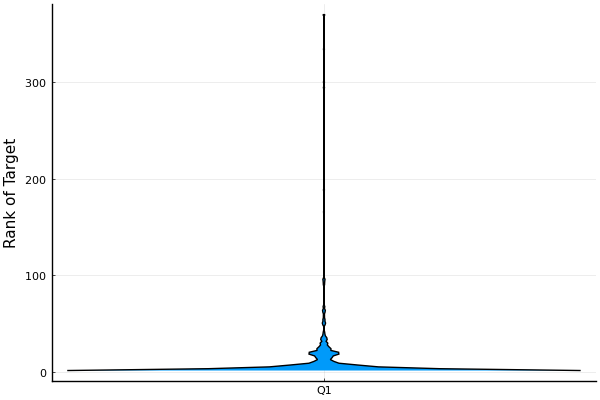

In [238]:
for (some_queries,some_indices) in zip(Iterators.partition(QUERIES, 2), Iterators.partition([1:length(QUERIES)...], 2))
    violin(
        [ranking_results[ranking_results[:,"query_id"].==q_id,"target_rank"] for q_id in some_indices],
        x_ticks = (some_indices,["Q$(i)" for i in some_indices]),
        legend = false,
        ylabel="Rank of Target"
)
end

## Performance vs Cosine Scoring Formulae <a id="anal-formulae"></a>
### [^Contents](#contents)

LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

## Performance vs Indexing Methods <a id="anal-indexing"></a>
### [^Contents](#contents)